In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import torch.optim as optim

### 搭建模型

In [ ]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output and out_channels==1:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.Sigmoid()
            )
        elif is_output:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.Softmax(dim=1)
            )   
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.Dropout(dropout),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True)
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=1):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 128)
        self.layer2 = LinearBNAC(128, 64)
        self.layer3 = LinearBNAC(64, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x 
        

<h1>Review of activation functions<h1>

[reference](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

$\color{green}{\text{Activation functions are applied to vectors before computing the loss during the training phase}}$

Sigmoid: $f(s_i) = \frac{1}{1+e^{-s_i}}$

Softmax: $f(s)_i = \frac{e^{s_i}}{Σ^{C}_{j}e^{s_j}}$

### 準備輸入資料、優化器、標籤資料、模型輸出

In [ ]:
model = Model(input_dimention=256,output_classes=10)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-3)

In [ ]:
batch_size = 4
input_features = 256
dummy_input = torch.randn(batch_size, input_features,)

#target = torch.empty(4, dtype=torch.float).random_(10)
target = torch.tensor([9., 5., 4., 4.], dtype=torch.long)

In [ ]:
output = model(dummy_input)
print(output)

tensor([[0.1455, 0.1040, 0.1023, 0.0687, 0.0686, 0.0981, 0.1268, 0.0919, 0.0616,
         0.1324],
        [0.1475, 0.1242, 0.0864, 0.0639, 0.0651, 0.1534, 0.0558, 0.0617, 0.0863,
         0.1557],
        [0.0925, 0.1342, 0.1510, 0.0344, 0.1087, 0.0479, 0.1601, 0.0620, 0.0702,
         0.1389],
        [0.1534, 0.0499, 0.0810, 0.0268, 0.1144, 0.1485, 0.0831, 0.0244, 0.2281,
         0.0904]], grad_fn=<SoftmaxBackward0>)


### 計算 CrossEntropy Loss
* 請注意哪一個 Loss最適合：我們已經使用 softmax
* 因為我們有使用dropout，並隨機產生dummy_input，所以各為學員得到的值會與解答不同，然而步驟原理需要相同



In [ ]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

In [ ]:
criterion = NLLLoss()

In [ ]:
loss = criterion(torch.log(output), target)

<h1>A note on loss functions</h1>

### Cross entropy loss

<h5>The cross-entropy (CE, also logistic loss, multinomial logistic) loss is defined as: </h5>

$CE=-\sum^{C}_{i}t_{i}log(s_i)$

In binary classification problem, where $C'=2$, the CE loss can be defined as: 

$CE = - \sum^{C'=2}_{i=1}t_ilog(s_i)$

$= -t_1log(s_1) - (1 - t_1)log(1 - s_1)$

Where $t_1$ and $s_1$ are the groundtruth and the score for $C_1$, and $t_2 = 1 - t_1$ and $s_2 = 1 - s_1$ are the groundtruth and the score for $C_2$

### Categorical CE loss
<h5>Also Softmax loss. Softmax activation + CE loss</h5>

- For binary classification
$CE = -log(\frac{e^{s_p}}{\sum^{C}_{j}e^{s_j}})$

- For multiclass classification
$CE = \frac{1}{M}\sum^{M}_{p}-log(\frac{e^{s_p}}{\sum^{C}_{j}e^{s_j}})$

###Back propagation

- calculating the CE loss with respect ot each CNN class

####  In binary classification problems: 
- The derivative with respect to the positive class: 
$\frac{\partial}{\partial s_p}(-log(\frac{e^{s_p}}{\sum^{C}_{j}e^{s_j}})) = (\frac{e^{s_p}}{\sum^{C}_{j}e^{s_j}} - 1)$ 

- The derivative with respect to the negative class: 
$\frac{\partial}{\partial s_n}(-log(\frac{e^{s_p}}{\sum^{C}_{j}e^{s_j}})) = (\frac{e^{s_n}}{\sum^{C}_{j}e^{s_j}})$ 

#### In multi-class classification (is not a standard practice(?)) 
- The derivative with respect to the positive class: 
$\frac{\partial}{\partial s_{pi}}(\frac{1}{M}\sum^{M}_{p}-log(\frac{e^{s_p}}{\sum^{C}_{j}e^{s_j}})) = \frac{1}{M}((\frac{e^{s_p}}{\sum^{C}_{j}e^{s_j}} - 1)+(M-1)\frac{e^{s_{pi}}}{\sum^{C}_{j}e^{s_j}})$

- The derivative with respect to the negative class: 
$\frac{\partial}{\partial s_n}(\frac{1}{M}\sum^{M}_{p}-log(\frac{e^{s_p}}{\sum^{C}_{j}e^{s_j}})) = (\frac{e^{s_n}}{\sum^{C}_{j}e^{s_j}})$

### Binary CE Loss
$CE = - \sum^{C'=2}_{i=1}t_ilog(f(s_i)) = -t_1log(f(s_1)) - (1 - t_1) log(1-f(s_1))$

The loss can be expressed as: 
$CE = 
\begin{cases}
   -log(f(s_1))& \text{if } t_1 = 1\\
  -log(1-f(s_1))& \text{if } t_1 = 0 
\end{cases}
$

The gradient with respect to the score $s_i = s_1$ can be written as: 

$\frac{\partial}{\partial{s_i}}(CE(f(s_i)) = t_1(f(s_1)-1+ (1-t_1)f(s_1)$

where $f()$ is the sigmoid function, which can also be written as:

$
\frac{\partial}{\partial{s_i}}(CE(f(s_i)) = 
\begin{cases} 
  f(s_i)-1 & \text{if } t_i = 1 \\
  f(s_i) & \text{if } t_i = 0 
\end{cases}
$



### 完成back propagation並更新梯度

In [ ]:
prediction = model(dummy_input)

In [ ]:
print('weight : {}'.format(model.layer1.linear[0].weight))
print('\n')
print('grad : {}'.format(model.layer1.linear[0].weight.grad))

weight : Parameter containing:
tensor([[ 0.0267, -0.0559,  0.0120,  ...,  0.0233, -0.0201,  0.0320],
        [-0.0037, -0.0105,  0.0023,  ...,  0.0329,  0.0090, -0.0028],
        [ 0.0595,  0.0544,  0.0251,  ...,  0.0117, -0.0206,  0.0057],
        ...,
        [-0.0467,  0.0190, -0.0611,  ...,  0.0204, -0.0264,  0.0381],
        [ 0.0509, -0.0256,  0.0047,  ...,  0.0191, -0.0414, -0.0320],
        [-0.0192,  0.0539, -0.0200,  ..., -0.0190,  0.0516,  0.0185]],
       requires_grad=True)


grad : None


In [ ]:
loss.backward()

In [ ]:
print('weight : {}'.format(model.layer1.linear[0].weight))
print('\n')
print('grad : {}'.format(model.layer1.linear[0].weight.grad))

weight : Parameter containing:
tensor([[ 0.0267, -0.0559,  0.0120,  ...,  0.0233, -0.0201,  0.0320],
        [-0.0037, -0.0105,  0.0023,  ...,  0.0329,  0.0090, -0.0028],
        [ 0.0595,  0.0544,  0.0251,  ...,  0.0117, -0.0206,  0.0057],
        ...,
        [-0.0467,  0.0190, -0.0611,  ...,  0.0204, -0.0264,  0.0381],
        [ 0.0509, -0.0256,  0.0047,  ...,  0.0191, -0.0414, -0.0320],
        [-0.0192,  0.0539, -0.0200,  ..., -0.0190,  0.0516,  0.0185]],
       requires_grad=True)


grad : tensor([[ 0.0077,  0.0035,  0.0068,  ...,  0.0012, -0.0070, -0.0047],
        [-0.0492,  0.0033, -0.0748,  ..., -0.0321,  0.0464,  0.0275],
        [ 0.0180, -0.0537, -0.0121,  ...,  0.0440,  0.0579,  0.0422],
        ...,
        [ 0.0118, -0.0402, -0.0260,  ...,  0.0081,  0.0490,  0.0332],
        [-0.0013, -0.0071,  0.0007,  ...,  0.0036,  0.0049,  0.0038],
        [-0.0851, -0.3213, -0.1223,  ..., -0.2052,  0.2245,  0.1436]])


### 清空 gradient

In [ ]:
optimizer.zero_grad()

In [ ]:
print('weight : {}'.format(model.layer1.linear[0].weight))
print('\n')
print('grad : {}'.format(model.layer1.linear[0].weight.grad))

weight : Parameter containing:
tensor([[ 0.0267, -0.0559,  0.0120,  ...,  0.0233, -0.0201,  0.0320],
        [-0.0037, -0.0105,  0.0023,  ...,  0.0329,  0.0090, -0.0028],
        [ 0.0595,  0.0544,  0.0251,  ...,  0.0117, -0.0206,  0.0057],
        ...,
        [-0.0467,  0.0190, -0.0611,  ...,  0.0204, -0.0264,  0.0381],
        [ 0.0509, -0.0256,  0.0047,  ...,  0.0191, -0.0414, -0.0320],
        [-0.0192,  0.0539, -0.0200,  ..., -0.0190,  0.0516,  0.0185]],
       requires_grad=True)


grad : tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


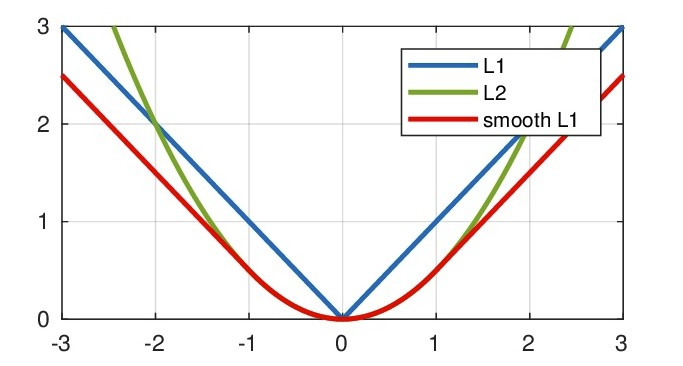